# PIFuHD

## Before we go

This code is based on [this jupyter notebook](https://colab.research.google.com/drive/11z58bl3meSzo6kFqkahMa35G5jmh2Wgt)

## Reference

- Saito, Shunsuke, et al. "Pifuhd: Multi-level pixel-aligned implicit function for high-resolution 3d human digitization." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2020.
- https://github.com/facebookresearch/pifuhd

In [1]:
import os

print("Current Directory:", os.getcwd())

Current Directory: /content


## Preparing Data

You can download the sampled image data from [this repository](https://github.com/facebookresearch/pifuhd/tree/main/sample_images). Download folder named 'sample_images' and zip it. Before you run the cell below, you need to locate the zip file in current directory. This code will unzip what you positioned.

In [2]:
from zipfile import ZipFile

files_name = [
    "sample_images.zip"
]

for file_name in files_name:
  if not os.path.exists(file_name[:-4]):
    if os.path.exists(file_name):
      with ZipFile(file_name, 'r') as zip:
        # zip.printdir()
        zip.extractall()

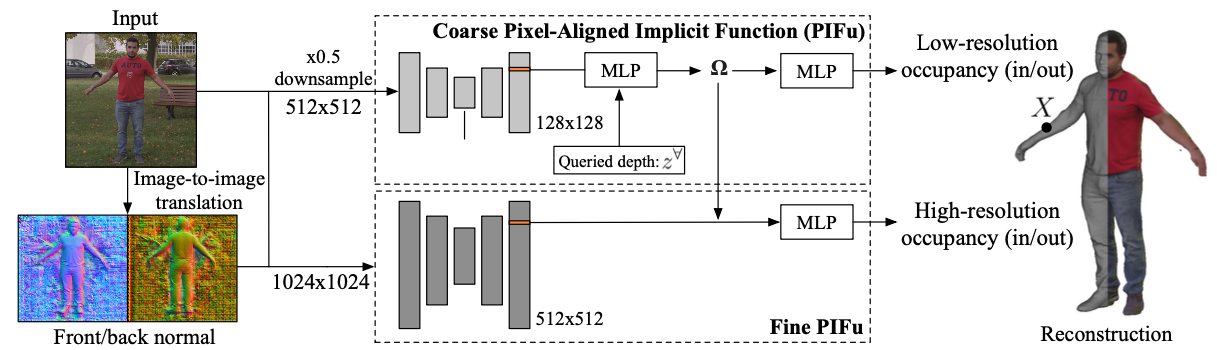

In [3]:
%matplotlib inline
from IPython.display import Image
Image("https://shunsukesaito.github.io/PIFuHD/resources/images/overview.png")

## Dataset

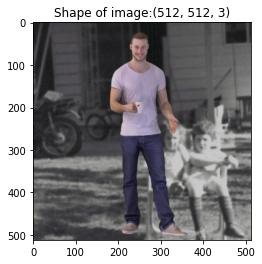

In [4]:
import matplotlib.pyplot as plt

input_path = "sample_images"
img_path = os.path.join(input_path, "test.png")

img = plt.imread(img_path)
plt.title(f"Shape of image:{img.shape}")
plt.imshow(img)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Utility

### Geometry Functions

#### License

MIT License

Copyright (c) 2019 Shunsuke Saito, Zeng Huang, and Ryota Natsume

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [6]:
def index(feat, uv):
  '''
  extract image features at floating coordinates with bilinear interpolation
  args:
    feat: [B, C, H, W] image features
    uv: [B, 2, N] normalized image coordinates ranged in [-1, 1]
  return:
    [B, C, N] sampled pixel values

  notation:
    B: batch
    C: channel
    H: height
    W: width
  '''

  uv = uv.transpose(1, 2)
  uv = uv.unsqueeze(2)

  # shape of uv: [B, N, C, 2]
  samples = torch.nn.functional.grid_sample(feat, uv, align_corners=True)

  return samples[:, :, :, 0]

In [7]:
def orthogonal(points, calib, transform=None):
  '''
  project points onto screen space using orthogonal projection
  args:
    points: [B, 3, N] 3d points in world coordinates
    calib: [B, 3, 4] projection matrix (generally dubbed as a matrix [R|t])
    transform: [B, 2, 3] screen space transformation
    return: 
      [B, 3, N] 3d coordinates in screen space
  '''

  rotation = calib[:, :3, :3]
  transition = calib[:, :3, 3:4]
  # shape of pts: (B, 3, N) = (B, 3, 1) + (B, 3, 3) * (B, 3, N) 
  pts = torch.baddbmm(transition, rotation, points)

  if transform is not None:
    scale = transform[:2, :2]
    shift = transform[:2, 2:3]
    # shape of pts: (B, 2, N) = (B, 2, 1) + (B, 2, 2) * (B, 2, N)
    pts[:, :2, :] = torch.baddbmm(shift, scale, pts[:, :2, :])

  return pts

In [8]:
def perspective(points, calib, transform=None):
  '''
  project points onto screen space using perspective projection
  args:
    points: [B, 3, N] 3d points in world coordinates
    calib: [B, 3, 4] projection matrix (generally dubbed as a matrix [R|t])
    transform: [B, 2, 3] screen space transformation
    return: 
      [B, 3, N] 3d coordinates in screen space
  '''

  rotation = calib[:, :3, :3]
  transition = calib[:, :3, 3:4]
  homo = torch.baddbmm(transition, rotation, points)
  xy = homo[:, :2, :] / homo[:, 2:3, :]

  if transform is not None:
    scale = transform[:2, :2]
    shift = transform[:2, 2:3]
    xy = torch.baddbmm(shift, scale, xy)
  
  xyz = torch.cat([xy, homo[:, 2:3, :]], 1)
  
  return xyz

### Net Utility

#### License

MIT License

Copyright (c) 2019 Shunsuke Saito, Zeng Huang, and Ryota Natsume

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [9]:
import functools
from torch.nn import init

def load_state_dict(state_dict, net):
    model_dict = net.state_dict()

    pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}                    

    for k, v in pretrained_dict.items():                      
        if v.size() == model_dict[k].size():
            model_dict[k] = v

    not_initialized = set()
            
    for k, v in model_dict.items():
        if k not in pretrained_dict or v.size() != pretrained_dict[k].size():
            not_initialized.add(k.split('.')[0])
    
    print('not initialized', sorted(not_initialized))
    net.load_state_dict(model_dict) 

    return net
    
def conv3x3(in_planes, out_planes, strd=1, padding=1, bias=False):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=strd, padding=padding, bias=bias)

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find(
                'BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0:
        assert (torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

class CustomBCELoss(nn.Module):
    def __init__(self, brock=False, gamma=None):
        super(CustomBCELoss, self).__init__()
        self.brock = brock
        self.gamma = gamma

    def forward(self, pred, gt, gamma, w=None):
        x_hat = torch.clamp(pred, 1e-5, 1.0-1e-5) # prevent log(0) from happening
        gamma = gamma[:,None,None] if self.gamma is None else self.gamma
        if self.brock:
            x = 3.0*gt - 1.0 # rescaled to [-1,2]

            loss = -(gamma*x*torch.log(x_hat) + (1.0-gamma)*(1.0-x)*torch.log(1.0-x_hat))
        else:
            loss = -(gamma*gt*torch.log(x_hat) + (1.0-gamma)*(1.0-gt)*torch.log(1.0-x_hat))

        if w is not None:
            if len(w.size()) == 1:
                w = w[:,None,None] 
            return (loss * w).mean()
        else:
            return loss.mean()

class CustomMSELoss(nn.Module):
    def __init__(self, gamma=None):
        super(CustomMSELoss, self).__init__()
        self.gamma = gamma

    def forward(self, pred, gt, gamma, w=None):
        gamma = gamma[:,None,None] if self.gamma is None else self.gamma
        weight = gamma * gt + (1.0-gamma) * (1 - gt)
        loss = (weight * (pred - gt).pow(2)).mean()

        if w is not None:
            return (loss * w).mean()
        else:
            return loss.mean()

def createMLP(dims, norm='bn', activation='relu', last_op=nn.Tanh(), dropout=False):
    act = None
    if activation == 'relu':
        act = nn.ReLU()
    if activation == 'lrelu':
        act = nn.LeakyReLU()
    if activation == 'selu':
        act = nn.SELU()
    if activation == 'elu':
        act = nn.ELU()
    if activation == 'prelu':
        act = nn.PReLU()

    mlp = []
    for i in range(1,len(dims)):
        if norm == 'bn':
            mlp += [  nn.Linear(dims[i-1], dims[i]),
                    nn.BatchNorm1d(dims[i])]
        if norm == 'in':
            mlp += [  nn.Linear(dims[i-1], dims[i]),
                    nn.InstanceNorm1d(dims[i])]
        if norm == 'wn':
            mlp += [  nn.utils.weight_norm(nn.Linear(dims[i-1], dims[i]), name='weight')]
        if norm == 'none':
            mlp += [ nn.Linear(dims[i-1], dims[i])]
        
        if i != len(dims)-1:
            if act is not None:
                mlp += [act]
            if dropout:
                mlp += [nn.Dropout(0.2)]

    if last_op is not None:
        mlp += [last_op]

    return mlp

### HGFilters

#### License

MIT License

Copyright (c) 2019 Shunsuke Saito, Zeng Huang, and Ryota Natsume

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_planes, out_planes, norm='batch'):
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, int(out_planes / 2))
        self.conv2 = conv3x3(int(out_planes / 2), int(out_planes / 4))
        self.conv3 = conv3x3(int(out_planes / 4), int(out_planes / 4))

        if norm == 'batch':
            self.bn1 = nn.BatchNorm2d(in_planes)
            self.bn2 = nn.BatchNorm2d(int(out_planes / 2))
            self.bn3 = nn.BatchNorm2d(int(out_planes / 4))
            self.bn4 = nn.BatchNorm2d(in_planes)
        elif norm == 'group':
            self.bn1 = nn.GroupNorm(32, in_planes)
            self.bn2 = nn.GroupNorm(32, int(out_planes / 2))
            self.bn3 = nn.GroupNorm(32, int(out_planes / 4))
            self.bn4 = nn.GroupNorm(32, in_planes)
        
        if in_planes != out_planes:
            self.downsample = nn.Sequential(
                self.bn4,
                nn.ReLU(True),
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=1, bias=False),
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        residual = x

        out1 = self.conv1(F.relu(self.bn1(x), True))
        out2 = self.conv2(F.relu(self.bn2(out1), True))
        out3 = self.conv3(F.relu(self.bn3(out2), True))

        out3 = torch.cat([out1, out2, out3], 1)

        if self.downsample is not None:
            residual = self.downsample(residual)
        
        out3 += residual

        return out3

class HourGlass(nn.Module):
    def __init__(self, depth, n_features, norm='batch'):
        super(HourGlass, self).__init__()
        self.depth = depth
        self.features = n_features
        self.norm = norm

        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module('b1_' + str(level), ConvBlock(self.features, self.features, norm=self.norm))
        self.add_module('b2_' + str(level), ConvBlock(self.features, self.features, norm=self.norm))

        if level > 1:
            self._generate_network(level - 1)
        else:
            self.add_module('b2_plus_' + str(level), ConvBlock(self.features, self.features, norm=self.norm))

        self.add_module('b3_' + str(level), ConvBlock(self.features, self.features, norm=self.norm))

    def _forward(self, level, inp):
        # upper branch
        up1 = inp 
        up1 = self._modules['b1_' + str(level)](up1)

        # lower branch
        low1 = F.avg_pool2d(inp, 2, stride=2)
        low1 = self._modules['b2_' + str(level)](low1)

        if level > 1:
            low2 = self._forward(level - 1, low1)
        else:
            low2 = low1
            low2 = self._modules['b2_plus_' + str(level)](low2)

        low3 = low2
        low3 = self._modules['b3_' + str(level)](low3)

        up2 = F.interpolate(low3, scale_factor=2, mode='bicubic', align_corners=True)
        # up2 = F.interpolate(low3, scale_factor=2, mode='bilinear')

        return up1 + up2
    
    def forward(self, x):
        return self._forward(self.depth, x)
        

class HGFilter(nn.Module):
    def __init__(self, stack, depth, in_ch, last_ch, norm='batch', down_type='conv64', use_sigmoid=True):
        super(HGFilter, self).__init__()
        self.n_stack = stack
        self.use_sigmoid = use_sigmoid
        self.depth = depth
        self.last_ch = last_ch
        self.norm = norm
        self.down_type = down_type

        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3)

        last_ch = self.last_ch

        if self.norm == 'batch':
            self.bn1 = nn.BatchNorm2d(64)
        elif self.norm == 'group':
            self.bn1 = nn.GroupNorm(32, 64)

        if self.down_type == 'conv64':
            self.conv2 = ConvBlock(64, 64, self.norm)
            self.down_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        elif self.down_type == 'conv128':
            self.conv2 = ConvBlock(128, 128, self.norm)
            self.down_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        elif self.down_type == 'ave_pool' or self.down_type == 'no_down':
            self.conv2 = ConvBlock(64, 128, self.norm)
        
        self.conv3 = ConvBlock(128, 128, self.norm)
        self.conv4 = ConvBlock(128, 256, self.norm)
        
        # start stacking
        for stack in range(self.n_stack):
            self.add_module('m' + str(stack), HourGlass(self.depth, 256, self.norm))

            self.add_module('top_m_' + str(stack), ConvBlock(256, 256, self.norm))
            self.add_module('conv_last' + str(stack),
                            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
            if self.norm == 'batch':
                self.add_module('bn_end' + str(stack), nn.BatchNorm2d(256))
            elif self.norm == 'group':
                self.add_module('bn_end' + str(stack), nn.GroupNorm(32, 256))
            
            self.add_module('l' + str(stack),
                            nn.Conv2d(256, last_ch, 
                            kernel_size=1, stride=1, padding=0))
            
            if stack < self.n_stack - 1:
                self.add_module(
                    'bl' + str(stack), nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.add_module(
                    'al' + str(stack), nn.Conv2d(last_ch, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), True)

        if self.down_type == 'ave_pool':
            x = F.avg_pool2d(self.conv2(x), 2, stride=2)
        elif self.down_type == ['conv64', 'conv128']:
            x = self.conv2(x)
            x = self.down_conv2(x)
        elif self.down_type == 'no_down':
            x = self.conv2(x)
        else:
            raise NameError('unknown downsampling type')
    
        x = self.conv3(x)
        x = self.conv4(x)

        previous = x

        outputs = []
        for i in range(self.n_stack):
            hg = self._modules['m' + str(i)](previous)

            ll = hg
            ll = self._modules['top_m_' + str(i)](ll)

            ll = F.relu(self._modules['bn_end' + str(i)]
                       (self._modules['conv_last' + str(i)](ll)), True)

            tmp_out = self._modules['l' + str(i)](ll)

            if self.use_sigmoid:
                outputs.append(nn.Tanh()(tmp_out))
            else:
                outputs.append(tmp_out)
            
            if i < self.n_stack - 1:
                ll = self._modules['bl' + str(i)](ll)
                tmp_out_ = self._modules['al' + str(i)](tmp_out)
                previous = previous + ll + tmp_out_
            
        return outputs 
    

### MLP

#### License

Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

In [11]:
class MLP(nn.Module):
    def __init__(self, 
                 filter_channels, 
                 merge_layer=0,
                 res_layers=[],
                 norm='group',
                 last_op=None):
        super(MLP, self).__init__()

        self.filters = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.merge_layer = merge_layer if merge_layer > 0 else len(filter_channels) // 2
        self.res_layers = res_layers
        self.norm = norm
        self.last_op = last_op

        for l in range(0, len(filter_channels)-1):
            if l in self.res_layers:
                self.filters.append(nn.Conv1d(
                    filter_channels[l] + filter_channels[0],
                    filter_channels[l+1],
                    1))
            else:
                self.filters.append(nn.Conv1d(
                    filter_channels[l],
                    filter_channels[l+1],
                    1))
            if l != len(filter_channels)-2:
                if norm == 'group':
                    self.norms.append(nn.GroupNorm(32, filter_channels[l+1]))
                elif norm == 'batch':
                    self.norms.append(nn.BatchNorm1d(filter_channels[l+1]))

    def forward(self, feature):
        '''
        feature may include multiple view inputs
        args:
            feature: [B, C_in, N]
        return:
            [B, C_out, N] prediction
        '''
        y = feature
        tmpy = feature
        phi = None
        for i, f in enumerate(self.filters):
            y = f(
                y if i not in self.res_layers
                else torch.cat([y, tmpy], 1)
            )
            if i != len(self.filters)-1:
                if self.norm not in ['batch', 'group']:
                    y = F.leaky_relu(y)
                else:
                    y = F.leaky_relu(self.norms[i](y))         
            if i == self.merge_layer:
                phi = y.clone()

        if self.last_op is not None:
            y = self.last_op(y)

        return y, phi


### Networks

#### License

Copyright (C) 2019 NVIDIA Corporation. Ting-Chun Wang, Ming-Yu Liu, Jun-Yan Zhu.
BSD License. All rights reserved. 

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

THE AUTHOR DISCLAIMS ALL WARRANTIES WITH REGARD TO THIS SOFTWARE, INCLUDING ALL 
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE. 
IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY SPECIAL, INDIRECT OR CONSEQUENTIAL 
DAMAGES OR ANY DAMAGES WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, 
WHETHER IN AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING 
OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.

In [12]:
import functools
from torch.autograd import Variable
import numpy as np

###############################################################################
# Functions
###############################################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def define_G(input_nc, output_nc, ngf, netG, n_downsample_global=3, n_blocks_global=9, n_local_enhancers=1, 
             n_blocks_local=3, norm='instance', gpu_ids=[], last_op=nn.Tanh()):    
    norm_layer = get_norm_layer(norm_type=norm)     
    if netG == 'global':    
        netG = GlobalGenerator(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, norm_layer, last_op=last_op)       
    elif netG == 'local':        
        netG = LocalEnhancer(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, 
                                  n_local_enhancers, n_blocks_local, norm_layer)
    elif netG == 'encoder':
        netG = Encoder(input_nc, output_nc, ngf, n_downsample_global, norm_layer)
    else:
        raise('generator not implemented!')
    # print(netG)
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())   
        netG.cuda(gpu_ids[0])
    netG.apply(weights_init)
    return netG

def print_network(net):
    if isinstance(net, list):
        net = net[0]
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

##############################################################################
# Generator
##############################################################################
class LocalEnhancer(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32, n_downsample_global=3, n_blocks_global=9, 
                 n_local_enhancers=1, n_blocks_local=3, norm_layer=nn.BatchNorm2d, padding_type='reflect'):        
        super(LocalEnhancer, self).__init__()
        self.n_local_enhancers = n_local_enhancers
        
        ###### global generator model #####           
        ngf_global = ngf * (2**n_local_enhancers)
        model_global = GlobalGenerator(input_nc, output_nc, ngf_global, n_downsample_global, n_blocks_global, norm_layer).model        
        model_global = [model_global[i] for i in range(len(model_global)-3)] # get rid of final convolution layers        
        self.model = nn.Sequential(*model_global)                

        ###### local enhancer layers #####
        for n in range(1, n_local_enhancers+1):
            ### downsample            
            ngf_global = ngf * (2**(n_local_enhancers-n))
            model_downsample = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf_global, kernel_size=7, padding=0), 
                                norm_layer(ngf_global), nn.ReLU(True),
                                nn.Conv2d(ngf_global, ngf_global * 2, kernel_size=3, stride=2, padding=1), 
                                norm_layer(ngf_global * 2), nn.ReLU(True)]
            ### residual blocks
            model_upsample = []
            for i in range(n_blocks_local):
                model_upsample += [ResnetBlock(ngf_global * 2, padding_type=padding_type, norm_layer=norm_layer)]

            ### upsample
            model_upsample += [nn.ConvTranspose2d(ngf_global * 2, ngf_global, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               norm_layer(ngf_global), nn.ReLU(True)]      

            ### final convolution
            if n == n_local_enhancers:                
                model_upsample += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]                       
            
            setattr(self, 'model'+str(n)+'_1', nn.Sequential(*model_downsample))
            setattr(self, 'model'+str(n)+'_2', nn.Sequential(*model_upsample))                  
        
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)

    def forward(self, input): 
        ### create input pyramid
        input_downsampled = [input]
        for i in range(self.n_local_enhancers):
            input_downsampled.append(self.downsample(input_downsampled[-1]))

        ### output at coarest level
        output_prev = self.model(input_downsampled[-1])        
        ### build up one layer at a time
        for n_local_enhancers in range(1, self.n_local_enhancers+1):
            model_downsample = getattr(self, 'model'+str(n_local_enhancers)+'_1')
            model_upsample = getattr(self, 'model'+str(n_local_enhancers)+'_2')            
            input_i = input_downsampled[self.n_local_enhancers-n_local_enhancers]            
            output_prev = model_upsample(model_downsample(input_i) + output_prev)
        return output_prev

class GlobalGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_downsampling=3, n_blocks=9, norm_layer=nn.BatchNorm2d, 
                 padding_type='reflect', last_op=nn.Tanh()):
        assert(n_blocks >= 0)
        super(GlobalGenerator, self).__init__()        
        activation = nn.ReLU(True)        

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0), norm_layer(ngf), activation]
        ### downsample
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf * mult * 2), activation]

        ### resnet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, activation=activation, norm_layer=norm_layer)]
        
        ### upsample         
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                       norm_layer(int(ngf * mult / 2)), activation]
        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        if last_op is not None:
            model += [last_op]        
        self.model = nn.Sequential(*model)
            
    def forward(self, input):
        return self.model(input)             
        
# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, activation=nn.ReLU(True), use_dropout=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, activation, use_dropout)

    def build_conv_block(self, dim, padding_type, norm_layer, activation, use_dropout):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim),
                       activation]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class Encoder(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32, n_downsampling=4, norm_layer=nn.BatchNorm2d):
        super(Encoder, self).__init__()        
        self.output_nc = output_nc        

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0), 
                 norm_layer(ngf), nn.ReLU(True)]             
        ### downsample
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]

        ### upsample         
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                       norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]        

        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]
        self.model = nn.Sequential(*model) 

    def forward(self, input, inst):
        outputs = self.model(input)

        # instance-wise average pooling
        outputs_mean = outputs.clone()
        inst_list = np.unique(inst.cpu().numpy().astype(int))        
        for i in inst_list:
            for b in range(input.size()[0]):
                indices = (inst[b:b+1] == int(i)).nonzero() # n x 4            
                for j in range(self.output_nc):
                    output_ins = outputs[indices[:,0] + b, indices[:,1] + j, indices[:,2], indices[:,3]]                    
                    mean_feat = torch.mean(output_ins).expand_as(output_ins)                                        
                    outputs_mean[indices[:,0] + b, indices[:,1] + j, indices[:,2], indices[:,3]] = mean_feat                       
        return outputs_mean


### Depth Normalizer

In [13]:
class DepthNormalizer(nn.Module):
    def __init__(self, opt):
        super(DepthNormalizer, self).__init__()
        self.opt = opt

    def forward(self, xyz, calibs=None, index_feat=None):
        '''
        normalize depth value
        args:
            xyz: [B, 3, N] depth value
        '''
        z_feat = xyz[:,2:3,:] * (self.opt.loadSize // 2) / self.opt.z_size

        return z_feat

## Models

### BasePIFuNet

#### License
Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

In [14]:
class BasePIFuNet(nn.Module):
  def __init__(self,
               projection_mode='orthogonal',
               criteria={'occ': nn.MSELoss()},
               ):
    '''
    args:
      projection_mode: orthogonal / perspective
      error_term: point-wise error term
    '''

    super(BasePIFuNet, self).__init__()
    self.name = 'base'

    self.criteria = criteria

    self.index = index
    self.projection = orthogonal if projection_mode == 'orthogonal' else perspective 
    
    self.preds = None
    self.labels = None
    self.normals = None
    self.labels_nml = None
    self.preds_surface = None

  
  def filter(self, images):
    '''
    apply a fully convolutional network to images.
    the resulting feature will be stored.
    args:
      images: [B, C, H, W]
    '''
    
    None

  def query(self, points, calibs, transforms=None, labels=None):
    '''
    given 3d points, we obtain 2d projection of these given the camera matrices.
    filter needs to be called beforehand.
    the prediction is stored to self.preds
    args:
      points: [B, 3, N] 3d points in world space
      calibs: [B, 3, 4] calibration matrices for each image
      transforms: [B, 2, 3] image space coordinate transforms
      labels: [B, C, N] ground truth labels (for supervision only)
    return:
      [B, C, N] prediction
    '''

    None

  def calc_normal(self, points, calibs, transforms=None, delta=0.1):
    '''
    return surface normal in 'model' space.
    it computes normal only in the last stack.
    note that the current implementation use forward difference.
    args:
      points: [B, 3, N] 3d points in world space
      calibs: [B, 3, 4] calibration matrices for each image
      transforms: [B, 2, 3] image space coordinate transforms
      delta: perturbation for finite differnece
    '''

    None

  def get_preds(self):
    '''
    return the current prediction.
    return:
      [B, C, N] prediction
    '''
    return self.preds

  def get_error(self, gamma=None):
    '''
    return the loss given the ground truth labels and prediction
    '''
    return self.error_term(self.preds, self.labels, gamma)

  def forward(self, points, images, calibs, transforms=None):
    '''
    args:
      points: [B, 3, N] 3d points in world space
      images: [B, C, H, W] input images
      calibs: [B, 3, 4] calibration matrics for each image
      transforms: [B, 2, 3] image space coordinate transforms
    return:
      [B, C, N] prediction corresponding to the given points
    '''
    self.filter(images)
    self.query(points, calibs, transforms)
    
    return self.get_preds()

In [32]:
class PIFuCoarse(BasePIFuNet):
  '''
  Coarse PIFu model with stacked hourglass as an image encoder.
  '''

  def __init__(self, 
               opt, 
               projection_mode="orthogonal", 
               criteria={"occ": nn.MSELoss()}):
    
    super(PIFuCoarse, self).__init__(
        projection_mode=projection_mode, criteria=criteria
    )

    self.opt = opt

    in_ch = 3 + 3 + 3
    self.image_filter = HGFilter(
        opt.num_stack, opt.hg_depth, in_ch, opt.hg_dim, opt.norm, opt.hg_down, False
    )

    self.mlp = MLP(
        filter_channels=self.opt.mlp_dim,
        merge_layer=self.opt.merge_layer,
        res_layers=self.opt.mlp_res_layers,
        norm=self.opt.mlp_norm,
        last_op=nn.Sigmoid()
    )
    
    # use pre-trained image-to-image translation model
    # get a normal map of the front
    self.netF = define_G(3, 3, 64, "global", 4, 9, 1, 3, "instance")
    # get a normal map of the backward
    self.netB = define_G(3, 3, 64, "global", 4, 9, 1, 3, "instance")

    self.spatial_enc = DepthNormalizer(opt)
    self.phi = None
    self.normal_front = None
    self.normal_backward = None
    init_net(self)

  def extract_feature(self, images):
    '''
    Extract image features from given images
    args:
      images: [B, 3, H, W] input images
    '''

    normals = []

    # gradient 계산 skip
    with torch.no_grad():
      self.normal_front = self.netF.forward(images).detach()
      normals.append(self.normal_front)
      self.normal_backward = self.netB.forward(images).detach()
      normals.append(self.normal_backward)
    
    normals = torch.cat(normals, 1)

    if images.size()[2:] != normals.size()[2:]:
      normals = nn.Upsample(
          size=images.size()[2:], mode="bilinear", align_corners=True
      )(normals)

    # channel dimension은 9
    images = torch.cat([images, normals], 1)
    self.im_feat = self.image_filter(images)

    if not self.training:
      self.im_feat = self.im_feat[-1]
    

  def query(self, points, calibs):
    """
    Predict occupancy fields given 3D sample points and camera parameters (calibs, same as poses)
    """

    # shape of xyz: [B, 3, N] depth value
    xyz = self.projection(points, calibs)
    xy = xyz[:, :2, :]

    # projection한 point가 이미지의 외부에 떨어지는지 내부에 떨어지는지
    in_bb = (xyz >= -1) & (xyz <= 1)
    in_bb = in_bb[:, 0, :] & in_bb[:, 1, :] & in_bb[:, 2, :]
    in_bb = in_bb[:, np.newaxis, :].detach().float()

    # spatial encoder로 depth 값을 구함
    sp_feat = self.spatial_enc(xyz, calibs=calibs)

    # xy에 대응되는 im_feature를 가져 옴 (grid_sample)
    pixel_features = self.index(self.im_feat, xy)
    pixel_features = torch.cat([pixel_features, sp_feat], 1)
    # phi: intermediate feature
    pred, phi = self.mlp(pixel_features)

    pred = in_bb * pred
    
    self.phi = phi
    self.preds = pred


In [36]:
class PIFuFine(BasePIFuNet):
  '''
  Fine PIFu model with stacked hourglass as an image encoder
  '''

  def __init__(
      self,
      opt,
      netG,
      projection_mode="orthogonal",
      criteria={"occ": nn.MSELoss()}
  ):
    super(PIFuFine, self).__init__(
        projection_mode=projection_mode, criteria=criteria
    )
    self.opt = opt

    in_ch = 3 + 3 + 3
    self.image_filter = HGFilter(
        opt.num_stack, opt.hg_depth, in_ch, opt.hg_dim, opt.norm, "no_down", False
    )

    self.mlp = MLP(
        filter_channels=self.opt.mlp_dim,
        merge_layer=-1,
        res_layers=self.opt.mlp_res_layers,
        norm=self.opt.mlp_norm,
        last_op=nn.Sigmoid()
    )

    init_net(self)

    # 실제로는 fine network가 coarse network를 품고 있는 구조처럼
    self.netG = netG

  def extract_feature_global(self, images):
    '''
    Extract coarse image feature from given images
    '''

    with torch.no_grad():
      self.netG.extract_feature(images)


  def extract_feature_local(self, images, rect=None):
    '''
    Extract fine image feature from given images and coarse image features
    '''

    normals = []
    normals.append(self.netG.normal_front)
    normals.append(self.netG.normal_backward)

    # 1024 X 1024의 크기로 들어가야 하므로 upsampling 수행
    normals = nn.Upsample(
        size=(self.opt.loadSizeBig, self.opt.loadSizeBig),
        mode="bilinear",
        align_corners=True
    )(torch.cat(normals, 1))

    # shape of images: [B, C, H, W, ]
    images = torch.cat(
        [images, normals[:, np.newaxis].expand(-1, images.size(1), -1, -1, -1)], dim=2
    )

    self.im_feat = self.image_filter(images.view(-1, *images.size()[2:]))

    if not self.training:
      self.im_feat = self.im_feat[-1]

  def query(self, points, calib_local):
      '''
      Predict occupancy fields given 3D sample points and camera parameters (calibs)

      argument로 depth value인 z가 아니라 coarse feature를 넘겨준다.
      '''

      calib_global = calib_local

      xyz = self.projection(points, calib_local)
      xy = xyz[:, :2, :]

      in_bb = (xyz >= -1) & (xyz <= 1)
      in_bb = in_bb[:, 0, :] & in_bb[:, 1, :]
      in_bb = in_bb[:, np.newaxis, :].detach().float()

      self.netG.query(points=points, calibs=calib_global)

      z_feat = self.netG.phi
      if not self.opt.train_full_pifu:
        z_feat = z_feat.detach()

      # xy에 대응되는 im_feature를 가져 옴 (grid_sample)
      pixel_features = self.index(self.im_feat.view(-1, *self.im_feat.size()[1:]), xy)
      pixel_features = torch.cat([pixel_features, z_feat], 1)

      pred = self.mlp(pixel_features)[0]
      pred = pred * in_bb

      self.preds = pred


## Mesh Utility

#### License
MIT License

Copyright (c) 2019 Shunsuke Saito, Zeng Huang, and Ryota Natsume

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.



In [17]:
import numpy as np


def create_grid(resX, resY, resZ, b_min=np.array([-1, -1, -1]), b_max=np.array([1, 1, 1]), transform=None):
    '''
    Create a dense grid of given resolution and bounding box
    :param resX: resolution along X axis
    :param resY: resolution along Y axis
    :param resZ: resolution along Z axis
    :param b_min: vec3 (x_min, y_min, z_min) bounding box corner
    :param b_max: vec3 (x_max, y_max, z_max) bounding box corner
    :return: [3, resX, resY, resZ] coordinates of the grid, and transform matrix from mesh index
    '''
    coords = np.mgrid[:resX, :resY, :resZ]
    coords = coords.reshape(3, -1)
    coords_matrix = np.eye(4)
    length = b_max - b_min
    coords_matrix[0, 0] = length[0] / resX
    coords_matrix[1, 1] = length[1] / resY
    coords_matrix[2, 2] = length[2] / resZ
    coords_matrix[0:3, 3] = b_min
    coords = np.matmul(coords_matrix[:3, :3], coords) + coords_matrix[:3, 3:4]
    if transform is not None:
        coords = np.matmul(transform[:3, :3], coords) + transform[:3, 3:4]
        coords_matrix = np.matmul(transform, coords_matrix)
    coords = coords.reshape(3, resX, resY, resZ)
    return coords, coords_matrix


def batch_eval(points, eval_func, num_samples=512 * 512 * 512):
    num_pts = points.shape[1]
    sdf = np.zeros(num_pts)

    num_batches = num_pts // num_samples
    for i in range(num_batches):
        sdf[i * num_samples:i * num_samples + num_samples] = eval_func(
            points[:, i * num_samples:i * num_samples + num_samples])
    if num_pts % num_samples:
        sdf[num_batches * num_samples:] = eval_func(points[:, num_batches * num_samples:])

    return sdf

def batch_eval_tensor(points, eval_func, num_samples=512 * 512 * 512):
    num_pts = points.size(1)

    num_batches = num_pts // num_samples
    vals = []
    for i in range(num_batches):
        vals.append(eval_func(points[:, i * num_samples:i * num_samples + num_samples]))
    if num_pts % num_samples:
        vals.append(eval_func(points[:, num_batches * num_samples:]))

    return np.concatenate(vals,0)

def eval_grid(coords, eval_func, num_samples=512 * 512 * 512):
    resolution = coords.shape[1:4]
    coords = coords.reshape([3, -1])
    sdf = batch_eval(coords, eval_func, num_samples=num_samples)
    return sdf.reshape(resolution)


def eval_grid_octree(coords, eval_func,
                     init_resolution=64, threshold=0.05,
                     num_samples=512 * 512 * 512):
    resolution = coords.shape[1:4]

    sdf = np.zeros(resolution)

    notprocessed = np.zeros(resolution, dtype=np.bool)
    notprocessed[:-1,:-1,:-1] = True
    grid_mask = np.zeros(resolution, dtype=np.bool)

    reso = resolution[0] // init_resolution

    while reso > 0:
        # subdivide the grid
        grid_mask[0:resolution[0]:reso, 0:resolution[1]:reso, 0:resolution[2]:reso] = True
        # test samples in this iteration
        test_mask = np.logical_and(grid_mask, notprocessed)
        # print('step size:', reso, 'test sample size:', test_mask.sum())
        points = coords[:, test_mask]

        sdf[test_mask] = batch_eval(points, eval_func, num_samples=num_samples)
        notprocessed[test_mask] = False

        # do interpolation
        if reso <= 1:
            break
        x_grid = np.arange(0, resolution[0], reso)
        y_grid = np.arange(0, resolution[1], reso)
        z_grid = np.arange(0, resolution[2], reso)

        v = sdf[tuple(np.meshgrid(x_grid, y_grid, z_grid, indexing='ij'))]

        v0 = v[:-1,:-1,:-1]
        v1 = v[:-1,:-1,1:]
        v2 = v[:-1,1:,:-1]
        v3 = v[:-1,1:,1:]
        v4 = v[1:,:-1,:-1]
        v5 = v[1:,:-1,1:]
        v6 = v[1:,1:,:-1]
        v7 = v[1:,1:,1:]

        x_grid = x_grid[:-1] + reso//2
        y_grid = y_grid[:-1] + reso//2
        z_grid = z_grid[:-1] + reso//2

        nonprocessed_grid = notprocessed[tuple(np.meshgrid(x_grid, y_grid, z_grid, indexing='ij'))]

        v = np.stack([v0,v1,v2,v3,v4,v5,v6,v7], 0)
        v_min = v.min(0)
        v_max = v.max(0)
        v = 0.5*(v_min+v_max)

        skip_grid = np.logical_and(((v_max - v_min) < threshold), nonprocessed_grid)

        n_x = resolution[0] // reso
        n_y = resolution[1] // reso
        n_z = resolution[2] // reso

        xs, ys, zs = np.where(skip_grid)
        for x, y, z in zip(xs*reso, ys*reso, zs*reso):
            sdf[x:(x+reso+1), y:(y+reso+1), z:(z+reso+1)] = v[x//reso,y//reso,z//reso]
            notprocessed[x:(x+reso+1), y:(y+reso+1), z:(z+reso+1)] = False
        reso //= 2

    return sdf.reshape(resolution)


In [28]:
from skimage import measure
import numpy as np
import torch

def reconstruction(
    net,
    cuda,
    calib_tensor,
    resolution,
    thresh=0.5,
    num_samples=10000,
):
    # Create grid points
    coords, mat = create_grid(resolution, resolution, resolution)
    calib = calib_tensor[0].cpu().numpy()
    calib_inv = np.linalg.inv(calib)
    coords = coords.reshape(3, -1).T
    # 주어진 3차원 물체를 camera coordinate로 변환
    coords = np.matmul(
        np.concatenate([coords, np.ones((coords.shape[0], 1))], 1), calib_inv.T
    )[:, :3]
    coords = coords.T.reshape(3, resolution, resolution, resolution)

    def eval_func(points):
        # occupancy fields 계산
        # batch dimension이 있다고 가정했으므로 차원 맞춰줘야 함
        points = np.expand_dims(points, axis=0)
        points = np.repeat(points, 1, axis=0)
        samples = torch.from_numpy(points).to(device=cuda).float()

        net.query(samples, calib_tensor)
        pred = net.get_preds()[0][0]
        return pred.detach().cpu().numpy()

    # num_samples 개수만큼 batch로 만들어서 예측
    sdf = eval_grid(coords, eval_func, num_samples=num_samples)
    # sdf에는 각 grid 좌표마다 물체에 속하지 않으면 0, 물체에 속하면 1로 occupancy 예측

    try:
        verts, faces, normals, values = measure.marching_cubes(sdf, thresh)
        trans_mat = np.matmul(calib_inv, mat)
        verts = np.matmul(trans_mat[:3, :3], verts.T) + trans_mat[:3, 3:4]
        verts = verts.T
        if np.linalg.det(trans_mat[:3, :3]) < 0.0:
            faces = faces[:, ::-1]
        return verts, faces, normals, values
    except:
        print("error cannot marching cubes")
        return -1


def save_obj_mesh(mesh_path, verts, faces=None):
    file = open(mesh_path, "w")

    for v in verts:
        file.write("v %.4f %.4f %.4f\n" % (v[0], v[1], v[2]))
    if faces is not None:
        for f in faces:
            if f[0] == f[1] or f[1] == f[2] or f[0] == f[2]:
                continue
            f_plus = f + 1
            file.write("f %d %d %d\n" % (f_plus[0], f_plus[2], f_plus[1]))
    file.close()


def save_obj_mesh_with_color(mesh_path, verts, faces, colors):
    file = open(mesh_path, "w")

    for idx, v in enumerate(verts):
        c = colors[idx]
        file.write(
            "v %.4f %.4f %.4f %.4f %.4f %.4f\n" % (v[0], v[1], v[2], c[0], c[1], c[2])
        )
    for f in faces:
        f_plus = f + 1
        file.write("f %d %d %d\n" % (f_plus[0], f_plus[2], f_plus[1]))
    file.close()


def save_obj_mesh_with_uv(mesh_path, verts, faces, uvs):
    file = open(mesh_path, "w")

    for idx, v in enumerate(verts):
        vt = uvs[idx]
        file.write("v %.4f %.4f %.4f\n" % (v[0], v[1], v[2]))
        file.write("vt %.4f %.4f\n" % (vt[0], vt[1]))

    for f in faces:
        f_plus = f + 1
        file.write(
            "f %d/%d %d/%d %d/%d\n"
            % (f_plus[0], f_plus[0], f_plus[2], f_plus[2], f_plus[1], f_plus[1])
        )
    file.close()


## EvalWPoseDataset

#### License

Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

In [19]:
import os
import random

import numpy as np 
from PIL import Image, ImageOps
from PIL.ImageFilter import GaussianBlur
import cv2
import torch
import json

from torch.utils.data import Dataset
import torchvision.transforms as transforms

def crop_image(img, rect):
    x, y, w, h = rect

    left = abs(x) if x < 0 else 0
    top = abs(y) if y < 0 else 0
    right = abs(img.shape[1]-(x+w)) if x + w >= img.shape[1] else 0
    bottom = abs(img.shape[0]-(y+h)) if y + h >= img.shape[0] else 0
    
    if img.shape[2] == 4:
        color = [0, 0, 0, 0]
    else:
        color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    x = x + left
    y = y + top

    return new_img[y:(y+h),x:(x+w),:]

def face_crop(pts):
    flag = pts[:,2] > 0.2

    mshoulder = pts[1,:2]
    rear = pts[18,:2]
    lear = pts[17,:2]
    nose = pts[0,:2]

    center = np.copy(mshoulder)
    center[1] = min(nose[1] if flag[0] else 1e8, lear[1] if flag[17] else 1e8, rear[1] if flag[18] else 1e8)

    ps = []
    pts_id = [0, 15, 16, 17, 18]
    cnt = 0
    for i in pts_id:
        if flag[i]:
            ps.append(pts[i,:2])
            if i in [17, 18]:
                cnt += 1

    ps = np.stack(ps, 0)
    if ps.shape[0] <= 1:
        raise IOError('key points are not properly set')
    if ps.shape[0] <= 3 and cnt != 2:
        center = ps[-1]
    else:
        center = ps.mean(0)
    radius = int(1.4*np.max(np.sqrt(((ps - center[None,:])**2).reshape(-1,2).sum(0))))


    # radius = np.max(np.sqrt(((center[None] - np.stack([]))**2).sum(0))
    # radius = int(1.0*abs(center[1] - mshoulder[1]))
    center = center.astype(int)

    x1 = center[0] - radius
    x2 = center[0] + radius
    y1 = center[1] - radius
    y2 = center[1] + radius

    return (x1, y1, x2-x1, y2-y1)

def upperbody_crop(pts):
    flag = pts[:,2] > 0.2

    mshoulder = pts[1,:2]
    ps = []
    pts_id = [8]
    for i in pts_id:
        if flag[i]:
            ps.append(pts[i,:2])

    center = mshoulder
    if len(ps) == 1:
        ps = np.stack(ps, 0)
        radius = int(0.8*np.max(np.sqrt(((ps - center[None,:])**2).reshape(-1,2).sum(1))))
    else:
        ps = []
        pts_id = [0, 2, 5]
        ratio = [0.4, 0.3, 0.3]
        for i in pts_id:
            if flag[i]:
                ps.append(pts[i,:2])
        ps = np.stack(ps, 0)
        radius = int(0.8*np.max(np.sqrt(((ps - center[None,:])**2).reshape(-1,2).sum(1)) / np.array(ratio)))

    center = center.astype(np.int)

    x1 = center[0] - radius
    x2 = center[0] + radius
    y1 = center[1] - radius
    y2 = center[1] + radius

    return (x1, y1, x2-x1, y2-y1)

def fullbody_crop(pts):
    flags = pts[:,2] > 0.5      #openpose
    # flags = pts[:,2] > 0.2  #detectron
    check_id = [11,19,21,22]
    cnt = sum(flags[check_id])

    if cnt == 0:
        center = pts[8,:2].astype(np.int)
        pts = pts[pts[:,2] > 0.5][:,:2]
        radius = int(1.45*np.sqrt(((center[None,:] - pts)**2).sum(1)).max(0))
        center[1] += int(0.05*radius)
    else:
        pts = pts[pts[:,2] > 0.2]
        pmax = pts.max(0)
        pmin = pts.min(0)

        center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
        radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))

    x1 = center[0] - radius
    x2 = center[0] + radius
    y1 = center[1] - radius
    y2 = center[1] + radius

    return (x1, y1, x2-x1, y2-y1)


class EvalWPoseDataset(Dataset):
    @staticmethod
    def modify_commandline_options(parser, is_train):
        return parser

    def __init__(self, opt, projection='orthogonal'):
        self.opt = opt
        self.projection_mode = projection

        self.root = self.opt.dataroot
        self.img_files = sorted([os.path.join(self.root,f) for f in os.listdir(self.root) if f.split('.')[-1] in ['png', 'jpeg', 'jpg', 'PNG', 'JPG', 'JPEG'] and os.path.exists(os.path.join(self.root,f.replace('.%s' % (f.split('.')[-1]), '_keypoints.json')))])
        self.IMG = os.path.join(self.root)

        self.phase = 'val'
        self.loadSize = self.opt.loadSize

        if self.opt.crop_type == 'face':
            self.crop_func = face_crop
        elif self.opt.crop_type == 'upperbody':
            self.crop_func = upperbody_crop
        else:
            self.crop_func = fullbody_crop

        # PIL to tensor
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # only used in case of multi-person processing
        self.person_id = 0

    def __len__(self):
        return len(self.img_files)

    def get_n_person(self, index):
        joint_path = self.img_files[index].replace('.%s' % (self.img_files[index].split('.')[-1]), '_keypoints.json')
        # Calib
        with open(joint_path) as json_file:
            data = json.load(json_file)
            return len(data['people'])            

    def get_item(self, index):
        img_path = self.img_files[index]
        joint_path = self.img_files[index].replace('.%s' % (self.img_files[index].split('.')[-1]), '_keypoints.json')
        # Name
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        # Calib
        with open(joint_path) as json_file:
            data = json.load(json_file)
            if len(data['people']) == 0:
                raise IOError('non human found!!')
            
            # if True, the person with the largest height will be chosen. 
            # set to False for multi-person processing
            if True:
                selected_data = data['people'][0]
                height = 0
                if len(data['people']) != 1:
                    for i in range(len(data['people'])):
                        tmp = data['people'][i]
                        keypoints = np.array(tmp['pose_keypoints_2d']).reshape(-1,3)

                        flags = keypoints[:,2] > 0.5 #openpose
                        # flags = keypoints[:,2] > 0.2  #detectron
                        if sum(flags) == 0:
                            continue
                        bbox = keypoints[flags]
                        bbox_max = bbox.max(0)
                        bbox_min = bbox.min(0)

                        if height < bbox_max[1] - bbox_min[1]:
                            height = bbox_max[1] - bbox_min[1]
                            selected_data = tmp
            else:
                pid = min(len(data['people'])-1, self.person_id)
                selected_data = data['people'][pid]

            keypoints = np.array(selected_data['pose_keypoints_2d']).reshape(-1,3)

            flags = keypoints[:,2] > 0.5   #openpose
            # flags = keypoints[:,2] > 0.2    #detectron

            nflag = flags[0]
            mflag = flags[1]

            check_id = [2, 5, 15, 16, 17, 18]
            cnt = sum(flags[check_id])
            if self.opt.crop_type == 'face' and (not (nflag and cnt > 3)):
                print('Waring: face should not be backfacing.')
            if self.opt.crop_type == 'upperbody' and (not (mflag and nflag and cnt > 3)):
                print('Waring: upperbody should not be backfacing.')
            if self.opt.crop_type == 'fullbody' and sum(flags) < 15:
                print('Waring: not sufficient keypoints.')

        im = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if im.shape[2] == 4:
            im = im / 255.0
            im[:,:,:3] /= im[:,:,3:] + 1e-8
            im = im[:,:,3:] * im[:,:,:3] + 0.5 * (1.0 - im[:,:,3:])
            im = (255.0 * im).astype(np.uint8)
        h, w = im.shape[:2]
        
        intrinsic = np.identity(4)

        trans_mat = np.identity(4)
        rect = self.crop_func(keypoints)

        im = crop_image(im, rect)

        scale_im2ndc = 1.0 / float(w // 2)
        scale = w / rect[2]
        trans_mat *= scale
        trans_mat[3,3] = 1.0
        trans_mat[0, 3] = -scale*(rect[0] + rect[2]//2 - w//2) * scale_im2ndc
        trans_mat[1, 3] = scale*(rect[1] + rect[3]//2 - h//2) * scale_im2ndc
        
        intrinsic = np.matmul(trans_mat, intrinsic)
        im_512 = cv2.resize(im, (512, 512))
        im = cv2.resize(im, (self.loadSize, self.loadSize))

        image_512 = Image.fromarray(im_512[:,:,::-1]).convert('RGB')
        image = Image.fromarray(im[:,:,::-1]).convert('RGB')
        
        B_MIN = np.array([-1, -1, -1])
        B_MAX = np.array([1, 1, 1])
        projection_matrix = np.identity(4)
        projection_matrix[1, 1] = -1
        calib = torch.Tensor(projection_matrix).float()

        calib_world = torch.Tensor(intrinsic).float()

        # image
        image_512 = self.to_tensor(image_512)
        image = self.to_tensor(image)
        return {
            'name': img_name,
            'img': image.unsqueeze(0),
            'img_512': image_512.unsqueeze(0),
            'calib': calib.unsqueeze(0),
            'calib_world': calib_world.unsqueeze(0),
            'b_min': B_MIN,
            'b_max': B_MAX,
        }

    def __getitem__(self, index):
        return self.get_item(index)


## Options

In [20]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

import argparse
import os

class BaseOptions():
    def __init__(self):
        self.initialized = False
        self.parser = None

    def initialize(self, parser):
        # Datasets related
        g_data = parser.add_argument_group('Data')
        g_data.add_argument('--dataset', type=str, default='renderppl', help='dataset name')
        g_data.add_argument('--dataroot', type=str, default='./data',
                            help='path to images (data folder)')

        g_data.add_argument('--loadSize', type=int, default=512, help='load size of input image')

        # Experiment related
        g_exp = parser.add_argument_group('Experiment')
        g_exp.add_argument('--name', type=str, default='',
                           help='name of the experiment. It decides where to store samples and models')
        g_exp.add_argument('--debug', action='store_true', help='debug mode or not')
        g_exp.add_argument('--mode', type=str, default='inout', help='inout || color')

        # Training related
        g_train = parser.add_argument_group('Training')
        g_train.add_argument('--tmp_id', type=int, default=0, help='tmp_id')
        g_train.add_argument('--gpu_id', type=int, default=0, help='gpu id for cuda')
        g_train.add_argument('--batch_size', type=int, default=32, help='input batch size')
        g_train.add_argument('--num_threads', default=1, type=int, help='# sthreads for loading data')
        g_train.add_argument('--serial_batches', action='store_true',
                             help='if true, takes images in order to make batches, otherwise takes them randomly')
        g_train.add_argument('--pin_memory', action='store_true', help='pin_memory')
        g_train.add_argument('--learning_rate', type=float, default=1e-3, help='adam learning rate')
        g_train.add_argument('--num_iter', type=int, default=30000, help='num iterations to train')
        g_train.add_argument('--freq_plot', type=int, default=100, help='freqency of the error plot')
        g_train.add_argument('--freq_mesh', type=int, default=20000, help='freqency of the save_checkpoints')
        g_train.add_argument('--freq_eval', type=int, default=5000, help='freqency of the save_checkpoints')
        g_train.add_argument('--freq_save_ply', type=int, default=5000, help='freqency of the save ply')
        g_train.add_argument('--freq_save_image', type=int, default=100, help='freqency of the save input image')
        g_train.add_argument('--resume_epoch', type=int, default=-1, help='epoch resuming the training')
        g_train.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        g_train.add_argument('--finetune', action='store_true', help='fine tuning netG in training C')

        # Testing related
        g_test = parser.add_argument_group('Testing')
        g_test.add_argument('--resolution', type=int, default=512, help='# of grid in mesh reconstruction')
        g_test.add_argument('--no_numel_eval', action='store_true', help='no numerical evaluation')
        g_test.add_argument('--no_mesh_recon', action='store_true', help='no mesh reconstruction')

        # Sampling related
        g_sample = parser.add_argument_group('Sampling')
        g_sample.add_argument('--num_sample_inout', type=int, default=6000, help='# of sampling points')
        g_sample.add_argument('--num_sample_surface', type=int, default=0, help='# of sampling points')
        g_sample.add_argument('--num_sample_normal', type=int, default=0, help='# of sampling points')
        g_sample.add_argument('--num_sample_color', type=int, default=0, help='# of sampling points')
        g_sample.add_argument('--num_pts_dic', type=int, default=1, help='# of pts dic you load')

        g_sample.add_argument('--crop_type', type=str, default='fullbody', help='Sampling file name.')
        g_sample.add_argument('--uniform_ratio', type=float, default=0.1, help='maximum sigma for sampling')
        g_sample.add_argument('--mask_ratio', type=float, default=0.5, help='maximum sigma for sampling')
        g_sample.add_argument('--sampling_parts', action='store_true', help='Sampling on the fly')
        g_sample.add_argument('--sampling_otf', action='store_true', help='Sampling on the fly')
        g_sample.add_argument('--sampling_mode', type=str, default='sigma_uniform', help='Sampling file name.')
        g_sample.add_argument('--linear_anneal_sigma', action='store_true', help='linear annealing of sigma')
        g_sample.add_argument('--sigma_max', type=float, default=0.0, help='maximum sigma for sampling')
        g_sample.add_argument('--sigma_min', type=float, default=0.0, help='minimum sigma for sampling')
        g_sample.add_argument('--sigma', type=float, default=1.0, help='sigma for sampling')
        g_sample.add_argument('--sigma_surface', type=float, default=1.0, help='sigma for sampling')
        
        g_sample.add_argument('--z_size', type=float, default=200.0, help='z normalization factor')

        # Model related
        g_model = parser.add_argument_group('Model')
        # General
        g_model.add_argument('--norm', type=str, default='batch',
                             help='instance normalization or batch normalization or group normalization')

        # Image filter General
        g_model.add_argument('--netG', type=str, default='hgpifu', help='piximp | fanimp | hghpifu')
        g_model.add_argument('--netC', type=str, default='resblkpifu', help='resblkpifu | resblkhpifu')

        # hgimp specific
        g_model.add_argument('--num_stack', type=int, default=4, help='# of hourglass')
        g_model.add_argument('--hg_depth', type=int, default=2, help='# of stacked layer of hourglass')
        g_model.add_argument('--hg_down', type=str, default='ave_pool', help='ave pool || conv64 || conv128')
        g_model.add_argument('--hg_dim', type=int, default=256, help='256 | 512')

        # Classification General
        g_model.add_argument('--mlp_norm', type=str, default='group', help='normalization for volume branch')
        g_model.add_argument('--mlp_dim', nargs='+', default=[257, 1024, 512, 256, 128, 1], type=int,
                             help='# of dimensions of mlp. no need to put the first channel')
        g_model.add_argument('--mlp_dim_color', nargs='+', default=[1024, 512, 256, 128, 3], type=int,
                             help='# of dimensions of mlp. no need to put the first channel')
        g_model.add_argument('--mlp_res_layers', nargs='+', default=[2,3,4], type=int,
                             help='leyers that has skip connection. use 0 for no residual pass')
        g_model.add_argument('--merge_layer', type=int, default=-1)

        # for train
        parser.add_argument('--random_body_chop', action='store_true', help='if random flip')
        parser.add_argument('--random_flip', action='store_true', help='if random flip')
        parser.add_argument('--random_trans', action='store_true', help='if random flip')
        parser.add_argument('--random_scale', action='store_true', help='if random flip')
        parser.add_argument('--random_rotate', action='store_true', help='if random flip')
        parser.add_argument('--random_bg', action='store_true', help='using random background')

        parser.add_argument('--schedule', type=int, nargs='+', default=[10, 15],
                            help='Decrease learning rate at these epochs.')
        parser.add_argument('--gamma', type=float, default=0.1, help='LR is multiplied by gamma on schedule.')
        parser.add_argument('--lambda_nml', type=float, default=0.0, help='weight of normal loss')
        parser.add_argument('--lambda_cmp_l1', type=float, default=0.0, help='weight of normal loss')
        parser.add_argument('--occ_loss_type', type=str, default='mse', help='bce | brock_bce | mse')
        parser.add_argument('--clr_loss_type', type=str, default='mse', help='mse | l1')
        parser.add_argument('--nml_loss_type', type=str, default='mse', help='mse | l1')
        parser.add_argument('--occ_gamma', type=float, default=None, help='weighting term')
        parser.add_argument('--no_finetune', action='store_true', help='fine tuning netG in training C')

        # for eval
        parser.add_argument('--val_test_error', action='store_true', help='validate errors of test data')
        parser.add_argument('--val_train_error', action='store_true', help='validate errors of train data')
        parser.add_argument('--gen_test_mesh', action='store_true', help='generate test mesh')
        parser.add_argument('--gen_train_mesh', action='store_true', help='generate train mesh')
        parser.add_argument('--all_mesh', action='store_true', help='generate meshs from all hourglass output')
        parser.add_argument('--num_gen_mesh_test', type=int, default=4,
                            help='how many meshes to generate during testing')

        # path
        parser.add_argument('--load_netG_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--load_netC_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--checkpoints_path', type=str, default='./checkpoints', help='path to save checkpoints')
        parser.add_argument('--results_path', type=str, default='./results', help='path to save results ply')
        parser.add_argument('--load_checkpoint_path', type=str, help='path to save results ply')
        parser.add_argument('--single', type=str, default='', help='single data for training')
        
        # for single image reconstruction
        parser.add_argument('--mask_path', type=str, help='path for input mask')
        parser.add_argument('--img_path', type=str, help='path for input image')

        # for multi resolution
        parser.add_argument('--load_netMR_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--loadSizeBig', type=int, default=1024, help='load size of input image')
        parser.add_argument('--loadSizeLocal', type=int, default=512, help='load size of input image')
        parser.add_argument('--train_full_pifu', action='store_true', help='enable end-to-end training')
        parser.add_argument('--num_local', type=int, default=1, help='number of local cropping')

        # for normal condition
        parser.add_argument('--load_netFB_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--load_netF_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--load_netB_checkpoint_path', type=str, help='path to save checkpoints')
        parser.add_argument('--use_aio_normal', action='store_true')
        parser.add_argument('--use_front_normal', action='store_true')
        parser.add_argument('--use_back_normal', action='store_true')
        parser.add_argument('--no_intermediate_loss', action='store_true')

        # aug
        group_aug = parser.add_argument_group('aug')
        group_aug.add_argument('--aug_alstd', type=float, default=0.0, help='augmentation pca lighting alpha std')
        group_aug.add_argument('--aug_bri', type=float, default=0.2, help='augmentation brightness')
        group_aug.add_argument('--aug_con', type=float, default=0.2, help='augmentation contrast')
        group_aug.add_argument('--aug_sat', type=float, default=0.05, help='augmentation saturation')
        group_aug.add_argument('--aug_hue', type=float, default=0.05, help='augmentation hue')
        group_aug.add_argument('--aug_gry', type=float, default=0.1, help='augmentation gray scale')
        group_aug.add_argument('--aug_blur', type=float, default=0.0, help='augmentation blur')

        # for reconstruction
        parser.add_argument('--start_id', type=int, default=-1, help='load size of input image')
        parser.add_argument('--end_id', type=int, default=-1, help='load size of input image')

        # special tasks
        self.initialized = True
        return parser

    def gather_options(self, args=None):
        # initialize parser with basic options
        if not self.initialized:
            parser = argparse.ArgumentParser(
                formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)
            self.parser = parser

        if args is None:
            return self.parser.parse_args()
        else:
            return self.parser.parse_args(args)

    def print_options(self, opt):
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

    def parse(self, args=None):
        opt = self.gather_options(args)

        opt.sigma = opt.sigma_max

        if len(opt.mlp_res_layers) == 1 and opt.mlp_res_layers[0] < 1:
            opt.mlp_res_layers = []
                
        return opt


## Overall Pipeline

In [21]:
import sys
import torch
import numpy as np
from tqdm import tqdm


In [22]:
def run_pifuhd(opt):
  cuda = torch.device("cuda:%d" % opt.gpu_id if torch.cuda.is_available() else "cpu")

  # checkpoint 불러오기
  state_dict_path = opt.load_netMR_checkpoint_path

  state_dict = None

  if state_dict_path is not None and os.path.exists(state_dict_path):
    print("Resuming from ", state_dict_path)
    state_dict = torch.load(state_dict_path, map_location=cuda)

    print("Warning: opt is overwritten")
    dataroot = opt.dataroot
    resolution = opt.resolution
    results_path = opt.results_path
    loadSize = opt.loadSize

    opt = state_dict["opt"]
    opt.dataroot = dataroot
    opt.resolution = resolution
    opt.results_path = results_path
    opt.loadSize = loadSize
  else:
    raise Exception("failed loading state dict!", state_dict_path)

  # Prepare datset
  test_dataset = EvalWPoseDataset(opt)
  print("test data size: ", len(test_dataset)) 
  projection_mode = test_dataset.projection_mode

  # Prepare model
  opt_netG = state_dict["opt_netG"]
  net_coarse = PIFuCoarse(opt_netG, projection_mode).to(device=cuda)
  net_fine = PIFuFine(opt, net_coarse, projection_mode).to(device=cuda)

  # Switch to evaluation mode
  def set_eval():
    net_coarse.eval()
    net_fine.eval()

  # Load checkpoints
  net_fine.load_state_dict(state_dict["model_state_dict"])

  os.makedirs(opt.checkpoints_path, exist_ok=True)
  os.makedirs(opt.results_path, exist_ok=True)
  os.makedirs("%s/%s/recon" % (opt.results_path, opt.name), exist_ok=True)

  start_id, end_id = 0, len(test_dataset)

  with torch.no_grad():
    set_eval()

    print("generate mesh (test) ...")

    for i in tqdm(range(start_id, end_id)):
      if i >= len(test_dataset):
        break

      test_data = test_dataset[i]
      save_path = "%s/%s/recon/result_%s_%d.obj" % (
          opt.results_path,
          opt.name,
          test_data["name"],
          opt.resolution
      )

      # Prepare input
      image_tensor_global = test_data["img_512"].to(device=cuda)
      image_tensor = test_data["img"].to(device=cuda)
      calib_tensor = test_data["calib"].to(device=cuda)

      # Extract image features
      net_fine.extract_feature_global(image_tensor_global)
      net_fine.extract_feature_local(image_tensor[:, np.newaxis])

      # Reconstruct with Pixel Aligned Implicit Functions

      verts, faces, _, _ = reconstruction(
          net_fine,
          cuda,
          calib_tensor,
          opt.resolution,
          thresh=0.5,
          num_samples=50000,
      )

      save_obj_mesh(save_path, verts, faces)
      print(f"saved the result at {save_path}")

In [23]:
# Setup default arguments
resolution = 512
input_path = "./sample_images"
out_path = "./results"
ckpt_path = "./checkpoints/pifuhd.pt"

## Download the Pretrained Model

In [24]:
sh = """
set -ex

mkdir -p checkpoints
cd checkpoints
wget "https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt" pifuhd.pt
cd ..
"""

if not os.path.exists("checkpoints"):
  with open('script.sh', 'w') as file:
    file.write(sh)
    
  !bash script.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2023-03-07 11:33:43--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt’

pifuhd.pt           100%[===================>]   1.44G  57.4MB/s    in 27s     

2023-03-07 11:34:10 (55.7 MB/s) - ‘pifuhd.pt’ saved [1548375177/1548375177]

--2023-03-07 11:34:10--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2023-03-07 11:34:10--
Total wall clock time: 27s
Downloaded: 1 files, 1.4G in 27s (55.7 MB/s)


## Run a model

Check if a desirable result was made on directory the option 'result_path' indicates.

In [37]:
parser = BaseOptions()

cmd = ['--dataroot', input_path, '--results_path', out_path,\
       '--loadSize', '1024', '--resolution', f"{resolution}", '--load_netMR_checkpoint_path', \
       ckpt_path]

def run_wrapper(args=None):
    opt = parser.parse(args)
    run_pifuhd(opt)
    
run_wrapper(cmd)

Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...


  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-9b73bc5999cf>:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
100%|██████████| 1/1 [00:33<00:00, 33.21s/it]

saved the result at ./results/pifuhd_final/recon/result_test_512.obj
